In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from models import BasicNN as net

In [1]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms



In [2]:
transforms = transforms.ToTensor()

# Get training and test datasets
train_data = MNIST("../data",
                     train=True,
                     download=True,
                     transform=transforms)
test_data = MNIST("../data",
                    train=False, 
                    transform=transforms)

# Print statistics about datasets
# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [5]:
# prepare data loaders, set the batch_size
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['zero', 'one', 'two', 'three', 'four', 
           'five', 'six', 'seven', 'eight', 'nine']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

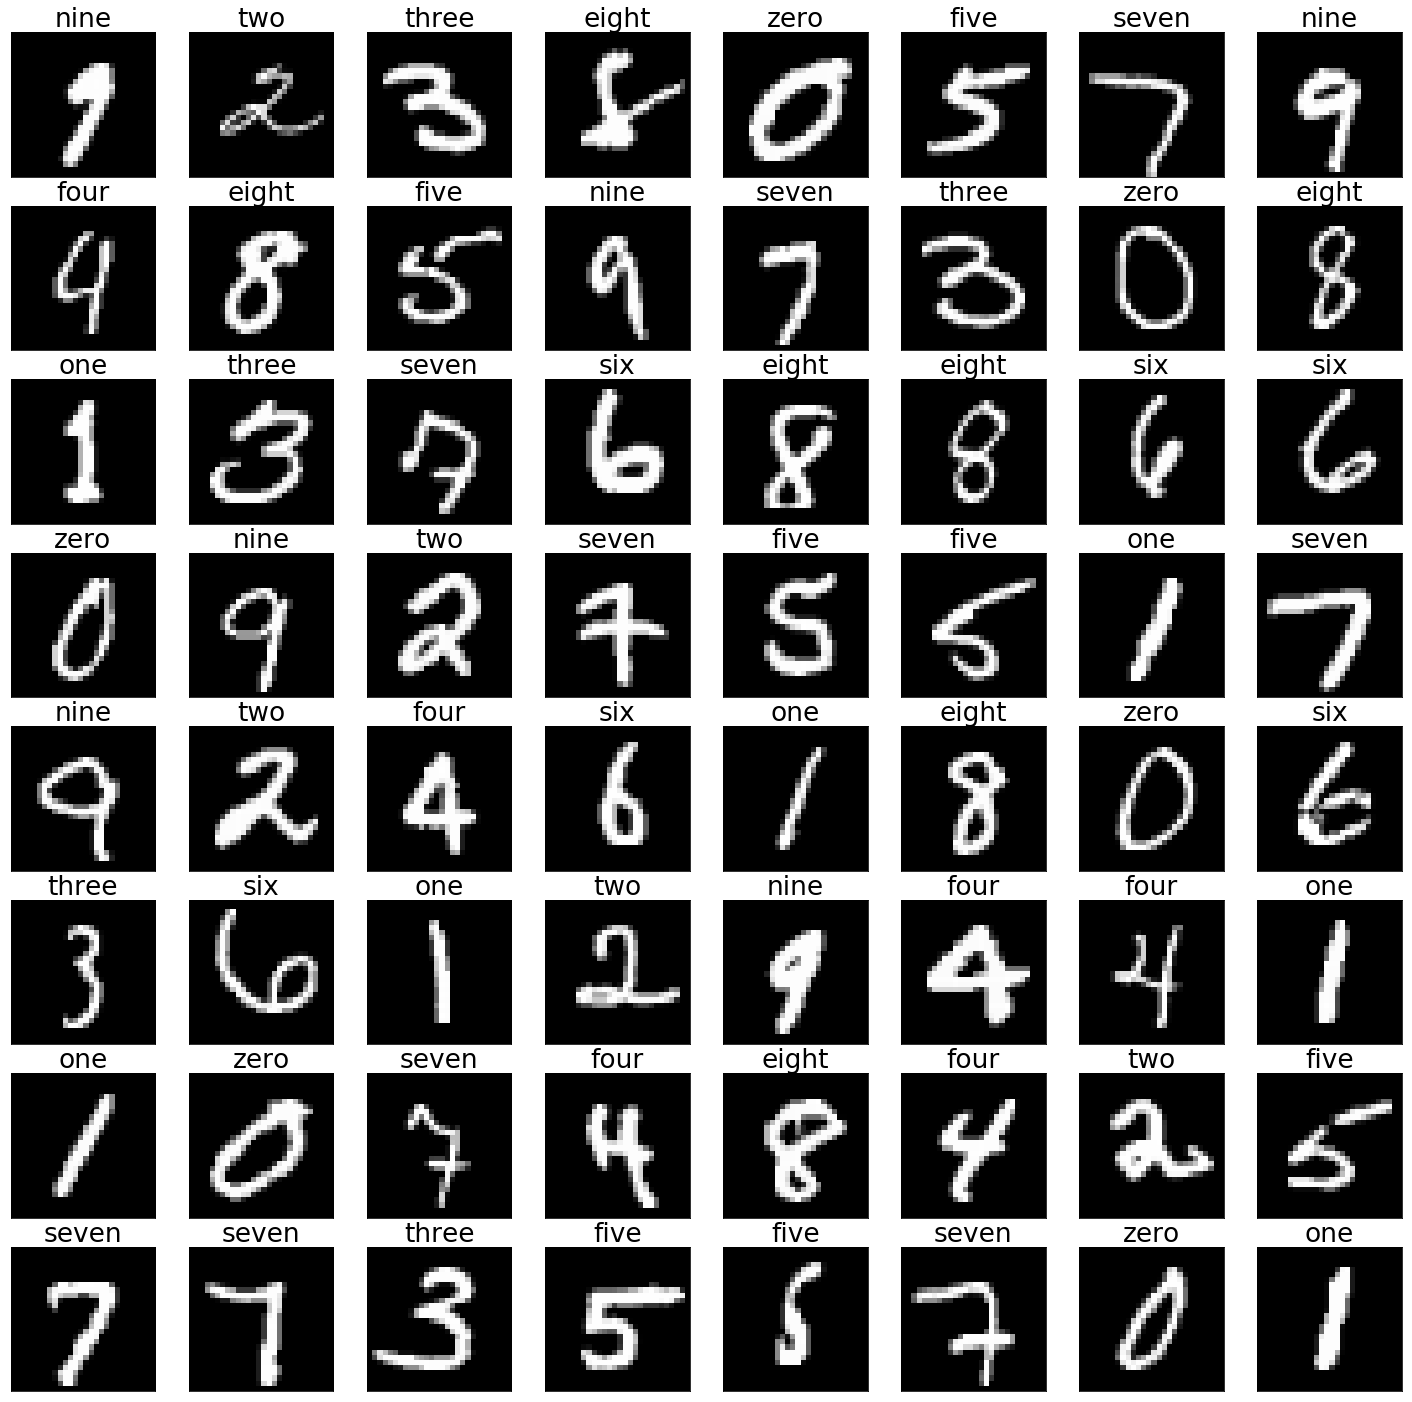

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 22})
for idx in np.arange(batch_size):
    ax = fig.add_subplot(8, batch_size/8, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [6]:
from models import Net1 as net

net = net()
print(net)

Net1(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


In [9]:
import torch.optim as optim
import torch.nn as nn

# cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.NLLLoss()

# stochastic gradient descent with a small learning rate
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [11]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  10.92


In [13]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [17]:
# define the number of epochs to train for
n_epochs = 30 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Finished Training


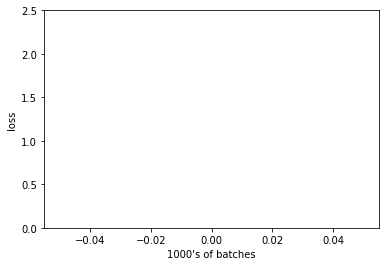

In [18]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

In [19]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

IndexError: index 16 is out of bounds for dimension 0 with size 16

In [3]:
def test():
    total_loss = 0
    correct = 0
    for image, label in test_loader:
        image, label = Variable(image), Variable(label)
        output = model(image)
        total_loss += F.cross_entropy(output, label)
        correct += (torch.max(output, 1)[1].view(label.size()).data == label.data).sum()
    total_loss = total_loss.data[0] / len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return total_loss, accuracy

In [4]:
def train():
    model.train()
    for image, label in train_loader:
        image, label = Variable(image), Variable(label)
        optimizer.zero_grad()
        output = model(image)
        loss = F.cross_entropy(output, label)
        loss.backward()
        optimizer.step()

In [7]:
model = net()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [8]:
best_test_loss = None
for e in range(1, 150):
    train()
    test_loss, test_accuracy = test()
    print("\n[Epoch: %d] Test Loss:%5.5f Test Accuracy:%5.5f" % (e, test_loss, test_accuracy))
    # Save the model if the test_loss is the lowest
    if not best_test_loss or test_loss < best_test_loss:
        best_test_loss = test_loss
    else:
        break
print("\nFinal Results\n-------------\n""Loss:", best_test_loss, "Test Accuracy: ", test_accuracy)

/home/z/Documents/MNIST-digits/models.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(output)
/home/z/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':



[Epoch: 1] Test Loss:2.29292 Test Accuracy:0.00000

[Epoch: 2] Test Loss:2.27849 Test Accuracy:0.00000

[Epoch: 3] Test Loss:2.25829 Test Accuracy:0.00000

[Epoch: 4] Test Loss:2.23068 Test Accuracy:0.00000

[Epoch: 5] Test Loss:2.20163 Test Accuracy:0.00000

[Epoch: 6] Test Loss:2.17279 Test Accuracy:0.00000

[Epoch: 7] Test Loss:2.14300 Test Accuracy:0.00000

[Epoch: 8] Test Loss:2.11193 Test Accuracy:0.00000

[Epoch: 9] Test Loss:2.08276 Test Accuracy:0.00000

[Epoch: 10] Test Loss:2.05748 Test Accuracy:0.00000

[Epoch: 11] Test Loss:2.03348 Test Accuracy:0.00000

[Epoch: 12] Test Loss:2.01242 Test Accuracy:0.00000

[Epoch: 13] Test Loss:1.99251 Test Accuracy:0.00000

[Epoch: 14] Test Loss:1.97371 Test Accuracy:0.00000

[Epoch: 15] Test Loss:1.95494 Test Accuracy:0.00000

[Epoch: 16] Test Loss:1.93864 Test Accuracy:0.00000

[Epoch: 17] Test Loss:1.92292 Test Accuracy:0.00000

[Epoch: 18] Test Loss:1.90940 Test Accuracy:0.00000

[Epoch: 19] Test Loss:1.89857 Test Accuracy:0.00000

[